In [68]:
import numpy as np
import glob
import re
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
# python -m spacy download en_core_web_sm
#nltk stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#pandas
import pandas as pd

#vis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /home/lennarth/Documents/
[nltk_data]     GitHub/nlp_project/venv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
df = pd.read_csv("../../data/ExtractedTweets.csv")
df.head()

# separate dataframes for both parties
df_dem = df.query("Party == 'Democrat'").sample(2000)
df_rep = df.query("Party == 'Republican'").sample(2000)

### Extract tweet information

In [70]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

# make new columns for retweeted usernames, mentioned usernames and hashtags
df_dem['retweeted'] = df_dem['Tweet'].apply(find_retweeted)
df_dem['mentioned'] = df_dem['Tweet'].apply(find_mentioned)
df_dem['hashtags'] = df_dem['Tweet'].apply(find_hashtags)

df_rep['retweeted'] = df_rep['Tweet'].apply(find_retweeted)
df_rep['mentioned'] = df_rep['Tweet'].apply(find_mentioned)
df_rep['hashtags'] = df_rep['Tweet'].apply(find_hashtags)

print("Extracted tweet metadata")

Extracted tweet metadata


### Clean metioned, retweets and hashtags from tweet

In [71]:
stop_words = stopwords.words('english')
stop_words.append("rt")

def clean_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.sub('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.sub('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean(tweet):
    # Remove mentions, retweets and hashtags
    tweet = clean_hashtags(tweet)
    tweet = clean_mentioned(tweet)
    tweet = clean_retweeted(tweet)
    tweet = tweet.lower()
    # Remove punctuation
    tweet = re.sub("[\\.,;:!/\\?]*", "", tweet)
    # Remove links
    tweet = re.sub(r"http\S+", "", tweet)
    # Remove stop words
    tweet = ' '.join([word for word in tweet.split(' ') if not word in stop_words])
    # Remove multiple spaces
    tweet = re.sub("\\s+", " ", tweet)
    return tweet

df_dem['TweetCleaned'] = df['Tweet'].apply(clean)
df_rep['TweetCleaned'] = df_rep['Tweet'].apply(clean)

print("Cleaned tweets")

Cleaned tweets


### Lemmatize the text

In [72]:
import warnings
# Ignore DeprecationWarning from SelectableGroups
warnings.filterwarnings("ignore", category=DeprecationWarning)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(tweet, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    doc = nlp(tweet)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return final

df_dem['TweetCleaned'] = df_dem['TweetCleaned'].apply(lemmatization)
df_rep['TweetCleaned'] = df_rep['TweetCleaned'].apply(lemmatization)

print("Lemmatized tweets")

Lemmatized tweets


In [73]:
def gen_words(tweet):
    # Use gensims simple_preprocess to remove accents, lowercase and tokenize
    return gensim.utils.simple_preprocess(tweet, deacc=True)

df_dem['TweetWords'] = df_dem['TweetCleaned'].apply(gen_words)
df_rep['TweetWords'] = df_rep['TweetCleaned'].apply(gen_words)

print("Generated tokens")

Generated tokens


In [54]:
# BIGRAMS AND TRIGRAMS
# DEM
# bigram_phrases_dem = gensim.models.Phrases(df_dem['TweetWords'], min_count=5, threshold=100)
# trigram_phrases_dem = gensim.models.Phrases(bigram_phrases_dem[df_dem['TweetWords']], threshold=100)
#
# bigram_dem = gensim.models.phrases.Phraser(bigram_phrases_dem)
# trigram_dem = gensim.models.phrases.Phraser(trigram_phrases_dem)
#
# # REP
# bigram_phrases_rep = gensim.models.Phrases(df_rep['TweetWords'], min_count=5, threshold=100)
# trigram_phrases_rep = gensim.models.Phrases(bigram_phrases_rep[df_rep['TweetWords']], threshold=100)
#
# bigram_rep = gensim.models.phrases.Phraser(bigram_phrases_rep)
# trigram_rep = gensim.models.phrases.Phraser(trigram_phrases_rep)
#
# def make_bigrams(tweetWords):
#     return bigram[tweetWords]
#
# def make_trigrams(bigrams):
#     return trigram[bigram[bigrams]]
#


def make_bigrams(tweetWords):
    bigram_phrases = gensim.models.Phrases(tweetWords, min_count=5, threshold=100)
    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    return bigram[tweetWords]

def make_trigrams(bigrams):
    trigram_phrases = gensim.models.Phrases(bigram_phrases[df['TweetWords']], threshold=100)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)
    return trigram[bigram[bigrams]]

df['bigramms'] =  df['TweetWords'].apply(make_bigrams)
df['trigrams'] = df['bigramms'].apply(make_trigrams)
df.head(30)

print("Generated trigrams")

Generated trigrams


In [55]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(df['trigrams'])

texts = df['trigrams']

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

print("TF-IDF removal")
print("Finish preprocessing")

TF-IDF removal
Finish preprocessing


In [56]:
import pickle
file = open("data.bin", "wb")
pickle.dump((df, id2word, corpus, tfidf), file)


In [57]:
import pickle
(df, id2word, corpus, tfidf) = pickle.load(open("data.bin", "rb"))
df.head()
texts = df['trigrams']

In [58]:
lda_model = gensim.models.LdaMulticore(
                corpus=corpus[:-1],
                id2word=id2word,
                num_topics=10,
                random_state=100,
                chunksize=100,
                passes=10
            )


In [59]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/lennarth/Documents/GitHub/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWar

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.099876  0.176791       1        1  12.761508
6      0.061520 -0.195776       2        1  12.342513
8      0.038741  0.209712       3        1  11.743331
0     -0.098770 -0.178886       4        1  10.981340
5     -0.181456  0.080083       5        1  10.751044
9      0.121009  0.113750       6        1   8.911514
4      0.186832 -0.115214       7        1   8.524068
3     -0.210704 -0.066816       8        1   8.422311
2      0.204939  0.027948       9        1   8.151409
7     -0.022234 -0.051592      10        1   7.410960, topic_info=             Term        Freq       Total Category  logprob  loglift
95            tax   60.000000   60.000000  Default  30.0000  30.0000
40          today  161.000000  161.000000  Default  29.0000  29.0000
1538       reform   25.000000   25.000000  Default  28.0000  28.0000
208          bill   55.000000   55.000000  Default  27.0000  27.0000
13            new   56.000000   56.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
136     community    4.367065   41.019326  Topic10  -5.6146   0.3623
72    opportunity    3.634101   18.528797  Topic10  -5.7983   0.9732
16           work    3.962582   67.480087  Topic10  -5.7118  -0.2327
159         woman    3.646944   32.250622  Topic10  -5.7948   0.4226
277          take    3.658537   40.932764  Topic10  -5.7916   0.1873

[692 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1797      3  0.178095         ability
1797      8  0.712381         ability
1736      8  0.698338  accountability
1627      1  0.894397     accountable
1208      5  0.668956         achieve
...     ...       ...             ...
1254      8  0.079209       yesterday
1254     10  0.039605       yesterday
4892      3  0.749222           yiqkx
1063      1  0.883198              yx
4864      6  0.782494           zhill

[1541 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 9, 1, 6, 10, 5, 4, 3, 8])

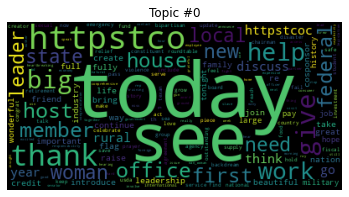

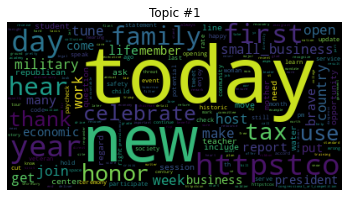

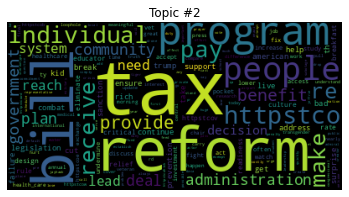

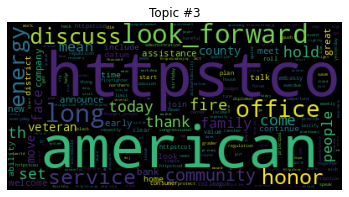

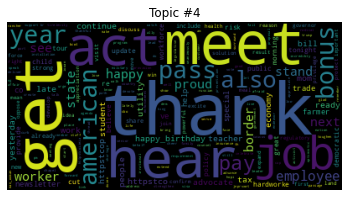

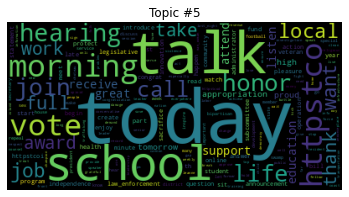

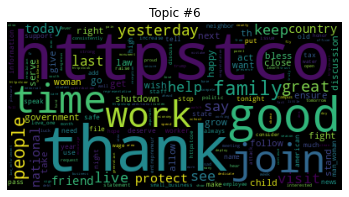

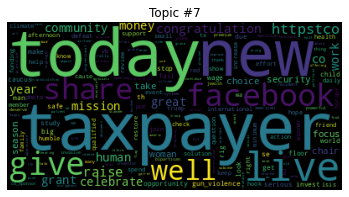

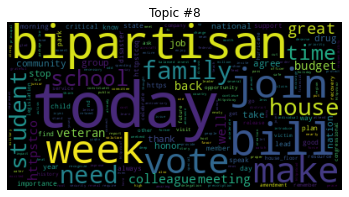

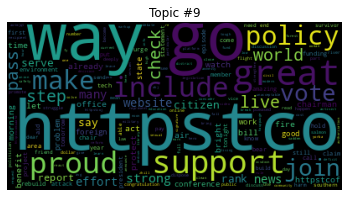

In [60]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()